In [1]:
import importers
import importlib
importlib.reload(importers)
from importers import SpikeImporter

data_folder = "../data/"
file_name = "11_10_27U2a_2000s_2300s_20000Hz_Force_BigFibre"
file_ending = ".csv"

time_channel = "Time"
signal_channel = "1 Signal"
stimulus_channel = "32 DigMark"
ap_marker_channels = ["801 nw-1", "12 nw-1"]
force_channel = "3 Force"

# load the animal file
importer = SpikeImporter(filepath = data_folder + file_name + file_ending, \
                         time_channel = time_channel, signal_channel = signal_channel, stimulus_channel = stimulus_channel, \
                         ap_marker_channels = ap_marker_channels, force_channel = force_channel)

print("Data loaded.")

Data loaded.


In [2]:
# define the max. time so that two sequential waveform-values are belonging to the same AP
# the time is in seconds, so 0.005 equals 5ms
max_gap_time = 0.005
force_thresh = 0.5

# retrieve the events from the importer 
el_stimuli = importer.getElectricalStimuli()
mech_stimuli = importer.getMechanicalStimuli(threshold = force_thresh, max_gap_time = 0.005)
actpots = importer.getActionPotentials(max_gap_time = max_gap_time, el_stimuli = el_stimuli, mech_stimuli = mech_stimuli)

List of eletrical stimuli created.
List of mechanical stimuli created.
List of APs created.


Clustering done.
['b' 'b' 'b' ... 'g' 'k' 'k']
['b' 'b' 'b' ... 'g' 'k' 'k']


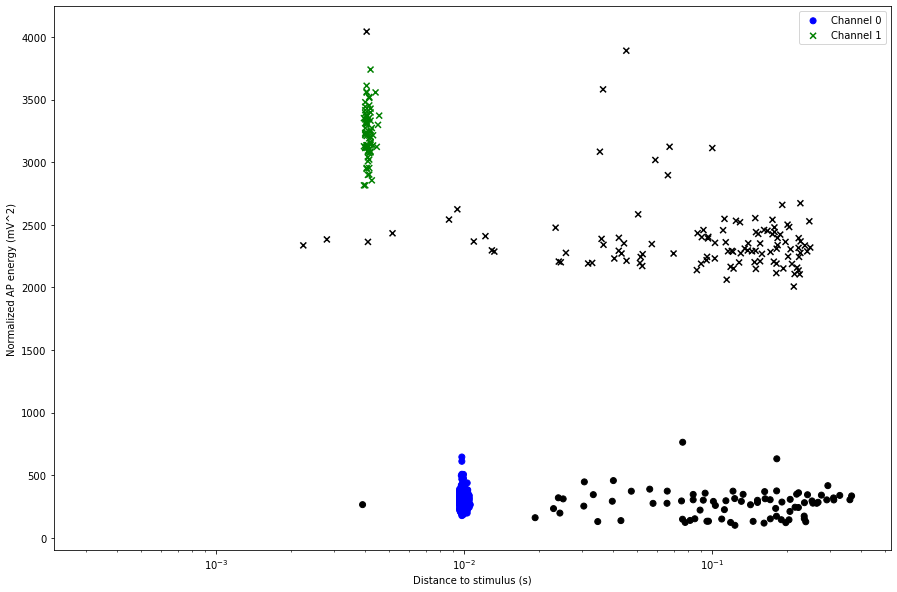

In [18]:
''' 
This cell performs the clustering according to
- distance to previous stimulus
- normalized signal energy of the APs
'''
import metrics
# reload the clustering classes
# hacky workaround atm
import importlib
importlib.reload(metrics)
from metrics import clustering_metrics

from sklearn.cluster import DBSCAN
import numpy as np

import matplotlib.pyplot as plt

# build feature vectors from the features provided by AP class
features = np.array([[ap.getDistanceToPreviousElectricalStimulus(), ap.getNormalizedEnergy()] for ap in actpots])
channel_indices = np.array([ap.getChannelIndex() for ap in actpots])
labels = DBSCAN(eps = 0.0025, min_samples = 10, metric = clustering_metrics.actionPotDistance_ElStim_Energy).fit_predict(features)
print("Clustering done.")

# initialize figure
plt.figure(figsize = (15, 10))

# where to save the results
results_folder = "../results/"
results_ending = ".png"

'''
# iterate over all the clusters and plot them
cluster_index = -1
while cluster_index <= max(labels):
    # get a mask for all samples belonging to the cluster and retrieve those feature vectors
    indices = (labels == cluster_index)
    print(indices)
    cluster_features = features[indices]
    
    # plot the cluster with the appropriate label
    # print("Plotting cluster: " + str(cluster_index))
    plt.scatter(x = cluster_features[: , 0], y = cluster_features[:, 1], label = "Cluster " + str(cluster_index) if cluster_index > -1 else "Noise")
    # go to the next cluster
    cluster_index = cluster_index + 1
'''

markers = ['o', 'x', 's', 'D']
cluster_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

channel_index = 0
while channel_index <= max(channel_indices):
    # get a mask for all APs from this channel
    indices = (channel_indices == channel_index)
    
    # get the 'cut' list of features and the colors corresponding to their cluster membership
    channel_features = features[indices, :]
    colors = np.array([cluster_colors[label] for label in labels])
    colors = colors[indices]
    
    # plot APs with marker according to channel index
    plt.scatter(x = channel_features[:, 0], y = channel_features[:, 1], c = colors, marker = markers[channel_index], label = "Template " + str(channel_index))
    
    channel_index = channel_index + 1

    
plt.xlabel("Distance to stimulus (s)")
plt.xscale('log')
# plt.xlim(0, 0.0125)
plt.ylabel("Normalized AP energy (mV^2)")
plt.legend()
plt.savefig(results_folder + "dbscan_clustering_" + file_name + results_ending, dpi = 400)
plt.show()